In [2]:
#!/usr/bin/env python
"""
Experimental suite for RAG system evaluation with support for Ragas metrics.
This script runs a series of experiments with different configurations to find optimal settings.

How to Use the Script

Phase 1 (Embedding Model Selection):
python run_experiment_suite.py --phase 1 --max_parallel 2

Phase 2 (Chunking Strategy Selection):
# After analyzing Phase 1 results
python run_experiment_suite.py --phase 2 --embedding_model "multi-qa-mpnet-base-dot-v1" --max_parallel 2

Phase 3 (Retriever Method Selection):
# After analyzing Phase 2 results
python run_experiment_suite.py --phase 3 --embedding_model "multi-qa-mpnet-base-dot-v1" --chunk_size 256 --chunk_overlap 50 --max_parallel 2

To use Ragas metrics instead of custom evaluators, add the --ragas flag:
python run_experiment_suite.py --phase 1 --max_parallel 2 --ragas
"""
import sys
import os
import time
import json
import argparse
import logging
import itertools
from tqdm import tqdm
from datetime import datetime
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, List, Any, Optional, Tuple, Union

# Load environment variables from .env file
load_dotenv()

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Import custom modules
from rag267.rag import RAGSystem
from rag267.vectordb.utils import Team, SupportedGeneratorModels, SupportedEmbeddingModels
from rag267.vectordb.manager import VectorDatabaseManager
from rag267.data_sources import data_sources

# Standard evaluators
from rag267.evals.correctness import correctness
from rag267.evals.relevance import relevance
from rag267.evals.retrieval_relevance import retrieval_relevance
from rag267.evals.groundedness import groundedness

# Ragas evaluators - Import the fixed versions
from rag267.evals.ragas.faithfulness import ragas_faithfulness
from rag267.evals.ragas.response_relevancy import ragas_response_relevancy
from rag267.evals.ragas.answer_accuracy import ragas_answer_accuracy
from rag267.evals.ragas.context_relevance import ragas_context_relevance

from langsmith import Client


class ExperimentConfig:
    """Configuration for a single experiment"""
    def __init__(
        self,
        rag_type: str,
        team_type: str,
        embedding_model: str,
        chunk_size: int,
        chunk_overlap: int,
        top_k: int,
        retriever_type: str,
        retriever_kwargs: Optional[Dict[str, Any]] = None,
        templates: Optional[Dict[str, str]] = None,
    ):
        self.rag_type = rag_type  # "cohere" or "mistral"
        self.team_type = team_type  # "engineering" or "marketing"
        self.embedding_model = embedding_model
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.top_k = top_k
        self.retriever_type = retriever_type
        self.retriever_kwargs = retriever_kwargs or {}
        
        # Default templates
        self.templates = {
            "engineering": "templates/engineering_template_3.txt",
            "marketing": "templates/marketing_template_2.txt"
        }
        
        # Override with provided templates if any
        if templates:
            self.templates.update(templates)
            
    def get_experiment_id(self) -> str:
        """Generate a unique experiment ID from the configuration"""
        retriever_extra = ""
        if self.retriever_type != "similarity":
            retriever_extra = f"-{self.retriever_type}"
            if "score_threshold" in self.retriever_kwargs:
                retriever_extra += f"-{self.retriever_kwargs['score_threshold']}"
                
        return (f"rag-{self.rag_type}-{self.team_type}"
                f"-emb-{self.embedding_model.split('/')[-1]}"
                f"-cs{self.chunk_size}-co{self.chunk_overlap}"
                f"-k{self.top_k}{retriever_extra}")
    
    def to_dict(self) -> Dict[str, Any]:
        """Convert config to dictionary for serialization"""
        return {
            "rag_type": self.rag_type,
            "team_type": self.team_type,
            "embedding_model": self.embedding_model,
            "chunk_size": self.chunk_size,
            "chunk_overlap": self.chunk_overlap,
            "top_k": self.top_k,
            "retriever_type": self.retriever_type,
            "retriever_kwargs": self.retriever_kwargs,
            "templates": self.templates
        }
    
    @classmethod
    def from_dict(cls, data: Dict[str, Any]) -> 'ExperimentConfig':
        """Create config from dictionary"""
        return cls(
            rag_type=data["rag_type"],
            team_type=data["team_type"],
            embedding_model=data["embedding_model"],
            chunk_size=data["chunk_size"],
            chunk_overlap=data["chunk_overlap"],
            top_k=data["top_k"],
            retriever_type=data["retriever_type"],
            retriever_kwargs=data.get("retriever_kwargs", {}),
            templates=data.get("templates", None)
        )


def create_phase1_experiments() -> List[ExperimentConfig]:
    """Create Phase 1 experiments: Embedding Model Comparison"""
    
    # Define the core parameters to test
    rag_models = ["cohere"] # TODO re-add cohere
    team_types = ["engineering", "marketing"]
    
    # Embedding models to test
    embedding_models = [
        # SupportedEmbeddingModels.MultiQaMpNetBasedDotV1.value,  # Baseline
        # SupportedEmbeddingModels.MpNetBaseV2.value,
        # SupportedEmbeddingModels.MiniLmL6V2.value,
        SupportedEmbeddingModels.DistilRobertaV1.value,
        SupportedEmbeddingModels.MultiQaMpNetBasedCosV1.value
    ]
    
    # Define a focused matrix of experiments
    experiments = []
    
    logger.info("Creating Phase 1 experiments - embedding model comparison")
    for rag_type, team_type, emb_model in itertools.product(rag_models, team_types, embedding_models):
        config = ExperimentConfig(
            rag_type=rag_type,
            team_type=team_type,
            embedding_model=emb_model,
            chunk_size=128,  # Baseline 
            chunk_overlap=0,  # Baseline
            top_k=4,          # Baseline
            retriever_type="similarity"  # Baseline
        )
        experiments.append(config)
    
    logger.info(f"Created {len(experiments)} experiments for Phase 1")
    return experiments


def create_phase2_experiments(best_embedding_model: str) -> List[ExperimentConfig]:
    """Create Phase 2 experiments: Chunk Size and Overlap Optimization"""

    # best performing embedding model from phase 1:
    # marketing: all-mpnet-base-v2
    # engineering: multi-qa-mpnet-base-dot-v1
    
    # Define the core parameters to test
    rag_models = ["cohere"] # TODO optionally add Mistral
    # TODO running on w267
    team_types = ["marketing"] # use for all-mpnet-base-v2
    # team_types = ["engineering"] # use for multi-qa-mpnet-base-dot-v1
    
    # Chunk sizes and overlaps to test
    chunk_sizes = [256, 512, 1024]
    chunk_overlaps = [0, 50]
    
    # Define a focused matrix of experiments
    experiments = []
    
    logger.info("Creating Phase 2 experiments - chunk size and overlap test")
    
    for rag_type, team_type, size, overlap in itertools.product(
            rag_models, team_types, chunk_sizes, chunk_overlaps):
        # Skip redundant experiments (baseline already covered in Phase 1)
        if size == 128 and overlap == 0:
            continue
            
        config = ExperimentConfig(
            rag_type=rag_type,
            team_type=team_type,
            embedding_model=best_embedding_model,
            chunk_size=size,
            chunk_overlap=overlap,
            top_k=4,  # Baseline
            retriever_type="similarity"  # Baseline
        )
        experiments.append(config)
    
    logger.info(f"Created {len(experiments)} experiments for Phase 2")
    return experiments


def create_phase3_experiments(best_embedding_model: str, best_chunk_size: int, 
                             best_chunk_overlap: int) -> List[ExperimentConfig]:
    """Create Phase 3 experiments: Retriever Method Optimization"""
    
    # Define the core parameters to test
    #rag_models = ["cohere", "mistral"]
    rag_models = ["cohere"]
    
    team_types = ["engineering", "marketing"]
    
    # Define a focused matrix of experiments
    experiments = []
    
    logger.info("Creating Phase 3 experiments - retriever type comparison")
    
    # Test different top_k values with similarity search
    for rag_type, team_type, k in itertools.product(rag_models, team_types, [5, 10]):
        config = ExperimentConfig(
            rag_type=rag_type,
            team_type=team_type, 
            embedding_model=best_embedding_model,
            chunk_size=best_chunk_size,
            chunk_overlap=best_chunk_overlap,
            top_k=k,
            retriever_type="similarity"
        )
        experiments.append(config)
    
    # Test similarity search with score thresholds
    for rag_type, team_type, threshold in itertools.product(rag_models, team_types, [0.5, 0.8]):
        config = ExperimentConfig(
            rag_type=rag_type,
            team_type=team_type,
            embedding_model=best_embedding_model,
            chunk_size=best_chunk_size,
            chunk_overlap=best_chunk_overlap,
            top_k=4,  # Baseline
            retriever_type="similarity_score_threshold",
            retriever_kwargs={"score_threshold": threshold}
        )
        experiments.append(config)
    
    # Test MMR retriever
    for rag_type, team_type in itertools.product(rag_models, team_types):
        config = ExperimentConfig(
            rag_type=rag_type,
            team_type=team_type,
            embedding_model=best_embedding_model,
            chunk_size=best_chunk_size,
            chunk_overlap=best_chunk_overlap,
            top_k=4,  # Baseline
            retriever_type="mmr",
            retriever_kwargs={"k": 4, "fetch_k": 10}  # Fetch more but return top 4
        )
        experiments.append(config)
    
    # Test multi-query retriever (one per LLM type)
    for rag_type, team_type in itertools.product(rag_models, team_types):
        # Use the same LLM for query generation as for the main RAG
        config = ExperimentConfig(
            rag_type=rag_type,
            team_type=team_type,
            embedding_model=best_embedding_model,
            chunk_size=best_chunk_size,
            chunk_overlap=best_chunk_overlap,
            top_k=4,  # Baseline
            retriever_type="multi_query",
            retriever_kwargs={"llm_for_queries": rag_type, "k": 4}
        )
        experiments.append(config)
    
    logger.info(f"Created {len(experiments)} experiments for Phase 3")
    return experiments


def load_validation_data() -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """Load validation data and prepare examples for both teams."""
    logger.info("Loading validation data")
    validation_file = os.path.join("data", "validation_question_answers.json")
    with open(validation_file, "r") as f:
        validation_question_answers = json.load(f)

    # Transform the data into LangSmith compatible examples
    examples_engineering = []
    examples_marketing = []

    for sample in validation_question_answers.values():
        examples_engineering.append({
            "inputs": {"question": sample["question"]},
            "outputs": {"answer": sample["gold_answer_research"]}
        })

        examples_marketing.append({
            "inputs": {"question": sample["question"]},
            "outputs": {"answer": sample["gold_answer_marketing"]}
        })
    
    return examples_engineering, examples_marketing


def get_or_create_dataset(client: Client, dataset_name: str, examples: List[Dict[str, Any]]):
    """Get or create a LangSmith dataset."""
    if client.has_dataset(dataset_name=dataset_name):
        logger.info(f"Dataset '{dataset_name}' already exists, loading existing dataset.")
        dataset = client.read_dataset(dataset_name=dataset_name)
    else:
        logger.info(f"Dataset '{dataset_name}' does not exist, creating it now.")
        dataset = client.create_dataset(dataset_name=dataset_name)
        client.create_examples(dataset_id=dataset.id, examples=examples)
    return dataset


def initialize_rag_system(config: ExperimentConfig, vdm: VectorDatabaseManager, cohere_api_key: str) -> RAGSystem:
    """Initialize a RAG system with the given configuration."""
    logger.info(f"Initializing {config.rag_type} RAG system with {config.retriever_type} retriever")
    
    use_cohere = config.rag_type == "cohere"
    use_mistral = config.rag_type == "mistral"
    
    return RAGSystem(
        vector_db_manager=vdm,
        engineering_template_path=config.templates["engineering"],
        marketing_template_path=config.templates["marketing"],
        cohere_api_key=cohere_api_key,
        use_mistral=use_mistral,
        use_cohere=use_cohere,
        mistral_model_name=SupportedGeneratorModels.MistralInstructV2.value,
        top_k=config.top_k,
        retriever_type=config.retriever_type,
        retriever_kwargs=config.retriever_kwargs,
    )


def create_target_function(rag_system: RAGSystem, team: Team):
    """Create a target function for evaluation with a specific rag system and team."""
    def target(inputs: dict) -> dict:
        question = inputs["question"]
        logger.info(f"Processing question: {question[:50]}...")
        answer = rag_system.invoke(team, question)
        retrieved_docs = rag_system.query_vectorstore(question)
        return {
            "answer": answer,
            "documents": retrieved_docs
        }
    return target


def run_evaluation(config: ExperimentConfig, cohere_api_key: str, use_ragas: bool = False) -> Dict[str, Any]:
    """Run a single evaluation with given experiment configuration."""
    import gc
    import torch
    
    # Initialize vector database manager
    vdm = VectorDatabaseManager(
        embedding_model_name=config.embedding_model,
        collection_name="myrag",
        chunk_size=config.chunk_size,
        chunk_overlap=config.chunk_overlap,
        in_memory=True,
        force_recreate=True,
    )
    
    # Hydrate vector database with data sources
    logger.info(f"Hydrating vector database with {len(data_sources)} data sources")
    vdm.hydrate(data_sources)
    
    # Initialize RAG system
    rag_system = initialize_rag_system(config, vdm, cohere_api_key)
    
    # Define team and dataset
    team = Team.Engineering if config.team_type == "engineering" else Team.Marketing
    dataset_name = f"w267-rag-validation-{config.team_type}"
    
    # Create LangSmith client
    client = Client()
    
    # Load validation data
    examples_engineering, examples_marketing = load_validation_data()
    examples = examples_engineering if config.team_type == "engineering" else examples_marketing
    
    # Get or create dataset
    dataset = get_or_create_dataset(client, dataset_name, examples)
    
    # Create target function
    target = create_target_function(rag_system, team)
    
    # Get experiment ID
    experiment_id = config.get_experiment_id()
    if use_ragas:
        experiment_id = f"ragas-{experiment_id}"
    logger.info(f"Starting evaluation: {experiment_id}")
    
    start_time = time.time()
    result_data = {}
    
    try:
        # Choose which evaluators to use based on the ragas flag
        if use_ragas:
            logger.info("Using Ragas evaluations")
            evaluators = [
                ragas_answer_accuracy, 
                ragas_context_relevance, 
                ragas_faithfulness, 
                ragas_response_relevancy
            ]
        else:
            logger.info("Using original evaluations")
            evaluators = [
                correctness, 
                groundedness, 
                relevance, 
                retrieval_relevance
            ]
        
        result = client.evaluate(
            target,
            data=dataset_name,
            evaluators=evaluators,
            experiment_prefix=experiment_id,
            metadata=rag_system.get_config(),
        )
        
        elapsed_time = time.time() - start_time
        logger.info(f"Evaluation completed in {elapsed_time:.1f} seconds: {experiment_id}")
        
        result_data = {
            "experiment_id": experiment_id,
            "config": config.to_dict(),
            "success": True,
            "elapsed_time": elapsed_time,
            "evaluation_type": "ragas" if use_ragas else "original"
        }
    
    except Exception as e:
        logger.error(f"Error in evaluation {experiment_id}: {e}", exc_info=True)
        
        result_data = {
            "experiment_id": experiment_id,
            "config": config.to_dict(),
            "success": False,
            "error": str(e),
            "evaluation_type": "ragas" if use_ragas else "original"
        }
    
    # Clean up to prevent memory leaks
    if config.rag_type == "mistral" and hasattr(rag_system, "llm") and hasattr(rag_system.llm, "pipeline"):
        logger.info(f"Cleaning up Mistral model for {experiment_id}")
        if hasattr(rag_system.llm.pipeline, "model"):
            # Delete the model to free GPU memory
            del rag_system.llm.pipeline.model
            
        # Delete the pipeline
        del rag_system.llm.pipeline
        
    # Delete the RAG system and vector DB manager
    del rag_system
    del vdm
    
    # Force garbage collection
    gc.collect()
    
    # If using CUDA, clear CUDA cache
    if torch.cuda.is_available():
        logger.info("Clearing CUDA cache")
        torch.cuda.empty_cache()
        
    return result_data

def custom_run_evaluation(
    config: ExperimentConfig, 
    cohere_api_key: str, 
    shared_vdm: VectorDatabaseManager,
    use_ragas: bool = False
) -> Dict[str, Any]:
    """Run a single evaluation with a pre-initialized vector database manager."""
    import gc
    import torch
    
    # Initialize RAG system with the shared vector store
    logger.info(f"Initializing {config.rag_type} RAG system with shared VDM")
    rag_system = initialize_rag_system(config, shared_vdm, cohere_api_key)
    
    # Define team and dataset
    team = Team.Engineering if config.team_type == "engineering" else Team.Marketing
    dataset_name = f"w267-rag-validation-{config.team_type}"
    
    # Create LangSmith client
    client = Client()
    
    # Load validation data
    examples_engineering, examples_marketing = load_validation_data()
    examples = examples_engineering if config.team_type == "engineering" else examples_marketing
    
    # Get or create dataset
    dataset = get_or_create_dataset(client, dataset_name, examples)
    
    # Create target function
    target = create_target_function(rag_system, team)
    
    # Get experiment ID
    experiment_id = config.get_experiment_id()
    if use_ragas:
        experiment_id = f"ragas-{experiment_id}"
    logger.info(f"Starting evaluation with shared VDM: {experiment_id}")
    
    start_time = time.time()
    result_data = {}
    
    try:
        # Choose which evaluators to use based on the ragas flag
        if use_ragas:
            logger.info("Using Ragas evaluations")
            evaluators = [
                ragas_answer_accuracy, 
                ragas_context_relevance, 
                ragas_faithfulness, 
                ragas_response_relevancy
            ]
        else:
            logger.info("Using original evaluations")
            evaluators = [
                correctness, 
                groundedness, 
                relevance, 
                retrieval_relevance
            ]
        
        # Set a timeout for evaluation (20 minutes)
        result = client.evaluate(
            target,
            data=dataset_name,
            evaluators=evaluators,
            experiment_prefix=experiment_id,
            metadata={**rag_system.get_config(), "using_shared_vectorstore": True},
            tags=["shared_vectorstore"]
        )
        
        elapsed_time = time.time() - start_time
        logger.info(f"Evaluation completed in {elapsed_time:.1f} seconds: {experiment_id}")
        
        result_data = {
            "experiment_id": experiment_id,
            "config": config.to_dict(),
            "success": True,
            "elapsed_time": elapsed_time,
            "evaluation_type": "ragas" if use_ragas else "original",
            "using_shared_vectorstore": True
        }
    
    except Exception as e:
        logger.error(f"Error in evaluation {experiment_id}: {e}", exc_info=True)
        
        result_data = {
            "experiment_id": experiment_id,
            "config": config.to_dict(),
            "success": False,
            "error": str(e),
            "evaluation_type": "ragas" if use_ragas else "original",
            "using_shared_vectorstore": True
        }
    
    # Clean up to prevent memory leaks
    if config.rag_type == "mistral" and hasattr(rag_system, "llm") and hasattr(rag_system.llm, "pipeline"):
        logger.info(f"Cleaning up Mistral model for {experiment_id}")
        if hasattr(rag_system.llm.pipeline, "model"):
            # Delete the model to free GPU memory
            del rag_system.llm.pipeline.model
            
        # Delete the pipeline
        del rag_system.llm.pipeline
        
    # Delete the RAG system but NOT the vector DB manager since it's shared
    del rag_system
    
    # Force garbage collection
    gc.collect()
    
    # If using CUDA, clear CUDA cache
    if torch.cuda.is_available():
        logger.cuda.empty_cache()
        
    return result_data

def run_experiment_phase(
    phase: int, 
    max_parallel: int = 2,
    best_params: Optional[Dict[str, Any]] = None,
    output_dir: Optional[str] = None,
    use_ragas: bool = False
) -> Dict[str, Any]:
    """Run experiments for a specific phase"""
    
    # Get API keys
    cohere_api_key = os.getenv("COHERE_API_KEY_PROD")
    if not cohere_api_key:
        logger.error("Error: COHERE_API_KEY_PROD environment variable not set")
        raise ValueError("COHERE_API_KEY_PROD environment variable is required")
    
    # Create timestamp-based directory if not provided
    if not output_dir:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        eval_type = "ragas" if use_ragas else "standard"
        output_dir = f"results/phase{phase}_{eval_type}_{timestamp}"
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Create experiments based on phase and best parameters from previous phases
    if phase == 1:
        experiments = create_phase1_experiments()
    elif phase == 2:
        if not best_params or 'embedding_model' not in best_params:
            raise ValueError("Phase 2 requires 'embedding_model' from Phase 1 results")
        experiments = create_phase2_experiments(best_params['embedding_model'])
    elif phase == 3:
        if not best_params or not all(k in best_params for k in ['embedding_model', 'chunk_size', 'chunk_overlap']):
            raise ValueError("Phase 3 requires 'embedding_model', 'chunk_size', and 'chunk_overlap' from Phase 2 results")
        experiments = create_phase3_experiments(
            best_params['embedding_model'], 
            best_params['chunk_size'], 
            best_params['chunk_overlap']
        )
    else:
        raise ValueError(f"Invalid phase: {phase}. Must be 1, 2, or 3.")
    
    # Save the experiment plan
    with open(f"{output_dir}/experiment_plan.json", "w") as f:
        json.dump([config.to_dict() for config in experiments], f, indent=4)
    
    # Split experiments by model type
    cohere_experiments = [exp for exp in experiments if exp.rag_type == "cohere"]
    mistral_experiments = [exp for exp in experiments if exp.rag_type == "mistral"]
    
    logger.info(f"Running {len(experiments)} experiments for Phase {phase}")
    logger.info(f"Running {len(cohere_experiments)} Cohere experiments with parallelism {max_parallel}")
    logger.info(f"Running {len(mistral_experiments)} Mistral experiments sequentially")
    
    results = []
    
    # Process Cohere experiments in parallel
    if cohere_experiments:
        logger.info(f"Starting Cohere experiments with {max_parallel} workers")
        with ThreadPoolExecutor(max_workers=max_parallel) as executor:
            # Submit all Cohere experiments
            futures = {executor.submit(run_evaluation, config, cohere_api_key, use_ragas): config 
                      for config in cohere_experiments}
            
            # Process results as they complete
            for future in tqdm(as_completed(futures), 
                              total=len(futures), 
                              desc="Cohere experiments"):
                config = futures[future]
                try:
                    result = future.result()
                    results.append(result)
                except Exception as e:
                    logger.error(f"Error in Cohere experiment {config.get_experiment_id()}: {e}", exc_info=True)
                    results.append({
                        "experiment_id": config.get_experiment_id(),
                        "config": config.to_dict(),
                        "success": False,
                        "error": str(e),
                        "evaluation_type": "ragas" if use_ragas else "original"
                    })
                
                # Save intermediate results after each experiment
                with open(f"{output_dir}/results.json", "w") as f:
                    json.dump(results, f, indent=4)
    
    # Process Mistral experiments sequentially
    if mistral_experiments:
        logger.info("Starting Mistral experiments (sequential execution)")
        for config in tqdm(mistral_experiments, desc="Mistral experiments"):
            try:
                result = run_evaluation(config, cohere_api_key, use_ragas)
                results.append(result)
            except Exception as e:
                logger.error(f"Error in Mistral experiment {config.get_experiment_id()}: {e}", exc_info=True)
                results.append({
                    "experiment_id": config.get_experiment_id(),
                    "config": config.to_dict(),
                    "success": False,
                    "error": str(e),
                    "evaluation_type": "ragas" if use_ragas else "original"
                })
            
            # Save intermediate results after each experiment
            with open(f"{output_dir}/results.json", "w") as f:
                json.dump(results, f, indent=4)
    
    # Process results to find best configurations
    successful_results = [r for r in results if r.get("success", False)]
    
    if not successful_results:
        logger.error("No successful experiments to analyze")
        return {"phase": phase, "results": results, "output_dir": output_dir, "success": False}
    
    logger.info(f"Completed {len(successful_results)}/{len(experiments)} experiments successfully")
    logger.info(f"Results saved to {output_dir}/results.json")
    
    return {
        "phase": phase,
        "results": results,
        "output_dir": output_dir,
        "success": True
    }


def parse_arguments():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser(description="Run RAG experiment suite")
    parser.add_argument("--phase", type=int, required=True, choices=[1, 2, 3],
                       help="Experiment phase to run (1, 2, or 3)")
    parser.add_argument("--max_parallel", type=int, default=2, 
                       help="Maximum number of parallel experiments (default: 2)")
    parser.add_argument("--output_dir", type=str, default=None,
                       help="Directory to save results (default: auto-generated)")
    
    # Parameters for Phase 2 and 3
    parser.add_argument("--embedding_model", type=str, default=None,
                       help="Best embedding model from Phase 1 (required for Phase 2 and 3)")
    
    # Parameters for Phase 3
    parser.add_argument("--chunk_size", type=int, default=None,
                       help="Best chunk size from Phase 2 (required for Phase 3)")
    parser.add_argument("--chunk_overlap", type=int, default=None,
                       help="Best chunk overlap from Phase 2 (required for Phase 3)")
    
    # Evaluation selector
    parser.add_argument("--ragas", action="store_true",
                       help="Use Ragas evaluations (answer_accuracy, context_relevance, faithfulness, response_relevancy)")
    
    # Timeout setting
    parser.add_argument("--timeout", type=int, default=1200,
                       help="Timeout in seconds for each experiment (default: 1200)")
    
    # Vectorstore reuse
    parser.add_argument("--no-reuse-vectorstore", action="store_true",
                       help="Disable vectorstore reuse (creates fresh vectorstore for each experiment)")
    
    return parser.parse_args()

In [ ]:
def load_validation_data(path: str = None, limit: int = 78) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """Load validation data and prepare examples for both teams."""
    logger.info("Loading validation data")
    validation_file = os.path.relpath(path) if path is not None else os.path.join("data", "validation_question_answers.json")
    with open(validation_file, "r") as f:
        validation_question_answers = json.load(f)

    # Transform the data into LangSmith compatible examples
    examples_engineering = []
    examples_marketing = []

    counter = 0
    for sample in validation_question_answers.values():
        
        if counter == limit:
            return examples_engineering, examples_marketing

        examples_engineering.append({
            "inputs": {"question": sample["question"]},
            "outputs": {"answer": sample["gold_answer_research"]}
        })

        examples_marketing.append({
            "inputs": {"question": sample["question"]},
            "outputs": {"answer": sample["gold_answer_marketing"]}
        })

        counter += 1
    
    return examples_engineering, examples_marketing

In [19]:
load_dotenv()

cohere_api_key = os.getenv("COHERE_API_KEY_PROD")
if not cohere_api_key:
    logger.error("Error: COHERE_API_KEY_PROD environment variable not set")
    raise ValueError("COHERE_API_KEY_PROD environment variable is required")

embedding_model = SupportedEmbeddingModels.MpNetBaseV2.value
use_ragas = True

config = ExperimentConfig(
    rag_type="cohere", 
    team_type="engineering", 
    embedding_model=embedding_model,
    chunk_size=512,
    chunk_overlap=50,
    templates={
        "engineering": "../templates/engineering_template_3.txt",
        "marketing": "../templates/marketing_template_2.txt"
    },
    retriever_type="similarity",
    top_k=10
)

vdm = VectorDatabaseManager(
    embedding_model_name=embedding_model,
    collection_name="myrag",
    chunk_size=config.chunk_size,
    chunk_overlap=config.chunk_overlap,
    in_memory=True,
    force_recreate=True,
)

vdm.hydrate(data_sources)

# Initialize RAG system with the shared vector store
logger.info(f"Initializing {config.rag_type} RAG system with shared VDM")
rag_system = initialize_rag_system(config, vdm, cohere_api_key)

# Define team
team = Team.Engineering if config.team_type == "engineering" else Team.Marketing

# Create LangSmith client
client = Client()

# Load validation data
examples_limit = 10
examples_engineering, examples_marketing = load_validation_data('../data/validation_question_answers.json', examples_limit)
examples = examples_engineering if config.team_type == "engineering" else examples_marketing

# Get or create dataset
dataset_name = f"w267-rag-validation-{config.team_type}-limit{examples_limit}"
dataset = get_or_create_dataset(client, dataset_name, examples)

# Create target function
target = create_target_function(rag_system, team)

# Get experiment ID
experiment_id = config.get_experiment_id()
if use_ragas:
    experiment_id = f"ragas-{experiment_id}"
logger.info(f"Starting evaluation with shared VDM: {experiment_id}")

start_time = time.time()
result_data = {}

try:
    # Choose which evaluators to use based on the ragas flag
    if use_ragas:
        logger.info("Using Ragas evaluations")
        evaluators = [
            ragas_answer_accuracy, 
            ragas_context_relevance, 
            ragas_faithfulness, 
            ragas_response_relevancy
        ]
    else:
        logger.info("Using original evaluations")
        evaluators = [
            correctness, 
            groundedness, 
            relevance, 
            retrieval_relevance
        ]

    # Set a timeout for evaluation (20 minutes)
    result = client.evaluate(
        target,
        data=dataset_name,
        evaluators=evaluators,
        experiment_prefix=experiment_id,
        metadata={**rag_system.get_config(), "using_shared_vectorstore": True}
    )

    elapsed_time = time.time() - start_time
    logger.info(f"Evaluation completed in {elapsed_time:.1f} seconds: {experiment_id}")

    result_data = {
        "experiment_id": experiment_id,
        "config": config.to_dict(),
        "success": True,
        "elapsed_time": elapsed_time,
        "evaluation_type": "ragas" if use_ragas else "original",
        "using_shared_vectorstore": True
    }

except Exception as e:
    logger.error(f"Error in evaluation {experiment_id}: {e}", exc_info=True)

2025-04-04 18:38:12,464 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cuda
2025-04-04 18:38:12,465 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2025-04-04 18:38:13.559 | INFO     | rag267.vectordb.utils:hydrate_vector_db:309 - Processing source: 2005.11401 (arxiv)
2025-04-04 18:38:15.391 | INFO     | rag267.vectordb.utils:split_and_add_documents:288 - Added 155 chunks to the vectorstore
2025-04-04 18:38:15.392 | INFO     | rag267.vectordb.utils:hydrate_vector_db:309 - Processing source: 2104.07567 (arxiv)
2025-04-04 18:38:17.885 | INFO     | rag267.vectordb.utils:split_and_add_documents:288 - Added 196 chunks to the vectorstore
2025-04-04 18:38:17.886 | INFO     | rag267.vectordb.utils:hydrate_vector_db:309 - Processing source: Generative Artificial Intelligence (wikipedia)
2025-04-04 18:38:19.257 | INFO     | rag267.vectordb.utils:split_and_add_documents:288 - Added 55 chunks to the vectorst

View the evaluation results for experiment: 'ragas-rag-cohere-engineering-emb-all-mpnet-base-v2-cs512-co50-k10-9ac8fa1b' at:
https://smith.langchain.com/o/b90a129f-4968-4c94-8e16-5eba475d05e8/datasets/a4b00549-54c7-4495-abcb-1c7884b7e4ff/compare?selectedSessions=d584a20d-e610-4375-adf9-1bf263e73d5f




0it [00:00, ?it/s]

2025-04-04 18:38:25,780 - __main__ - INFO - Processing question: What licensing terms are associated with source-av...
2025-04-04 18:38:26,461 - httpx - INFO - HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
2025-04-04 18:38:26.485 | INFO     | rag267.evals.ragas.answer_accuracy:ragas_answer_accuracy:18 - Inputs structure: dict_keys(['question'])
2025-04-04 18:38:26.489 | INFO     | rag267.evals.ragas.answer_accuracy:ragas_answer_accuracy:30 - Searching for reference in dataset: w267-rag-validation-engineering
2025-04-04 18:38:28.363 | INFO     | rag267.evals.ragas.answer_accuracy:ragas_answer_accuracy:42 - Found reference answer for question
2025-04-04 18:38:28.364 | INFO     | rag267.evals.ragas.answer_accuracy:ragas_answer_accuracy:50 - Question: What licensing terms are associated with source-av...
2025-04-04 18:38:28.365 | INFO     | rag267.evals.ragas.answer_accuracy:ragas_answer_accuracy:51 - Generated answer: Source-available models such as Mistral AI's Mist

In [20]:
display(type(result))
display(result)

langsmith.evaluation._runner.ExperimentResults

,inputs.question,outputs.answer,outputs.documents,error,reference.answer,feedback.ragas_answer_accuracy,feedback.ragas_context_relevance,feedback.ragas_faithfulness,feedback.ragas_response_relevancy,execution_time,example_id,id
0,What licensing terms are associated with sourc...,Source-available models such as Mistral AI's M...,"[page_content='Since 2022, source-available mo...",None,Source-available models like Mistral AI's lang...,0.50,1.0,1.000000,0.677256,0.703768,0b2575e6-9827-4c56-ab94-638631cb76dd,500ff76c-5855-46ad-89ea-defd5ccb0f6f
1,What is a common strategy used by language mod...,One common strategy employed by language model...,"[page_content='Large language models (LLMs), c...",None,One common strategy used by language models to...,0.25,0.0,0.000000,0.993943,0.626112,185d57d5-5cd5-48a5-8d24-4bfa9b647169,a33e9afc-1a8f-4cf2-b388-fc072b92f252
2,Who proposed the first significant statistical...,The first significant statistical language mod...,[page_content='== History ==\nNoam Chomsky did...,None,The first significant statistical language mod...,0.75,1.0,0.250000,0.963912,0.585318,2fc734db-8f49-4fe8-a3ab-3285f40d6023,453b992b-332e-4739-8bbe-23671d6a60b1
3,What defines a large language model in the con...,A large language model (LLM) is defined by its...,"[page_content='Large language models (LLMs), c...",None,A large language model in the context of natur...,0.50,1.0,0.800000,0.696915,0.545529,3dc5a44c-ca54-490c-8613-8ca985180ecd,63102a9d-4647-4970-99f5-dff5df93698d
4,How do large language models like GPT-3 become...,"Large Language Models (LLMs), such as GPT-3, e...",[page_content='== Background ==\nAfter the rel...,None,Large language models like GPT-3 become capabl...,0.50,1.0,1.000000,0.833702,0.583712,556df3d5-f870-482f-8dbc-137f27778abc,b6678636-f12c-4727-827e-adf636c0c366
5,Why might large language models not be conside...,Large Language Models (LLMs) are unlikely to b...,[page_content='== Background ==\nAfter the rel...,None,Large language models may not be considered pl...,0.50,0.0,0.142857,0.891881,0.701236,7050b89d-8977-4435-91f9-9ff01ddeb199,3d0da8a4-171c-4cce-b9eb-355afd5e0f2b
6,Which components have allowed large language m...,Large Language Models' success is attributed t...,"[page_content='Before 2017, there were a few l...",None,Large language models have surpassed their pre...,0.75,1.0,1.000000,0.729604,0.559764,87c4388a-6acf-44a3-96cc-2be3238bb142,e905f67e-0206-4a7c-8158-f993e20656e3
7,Can you name some notable large language model...,Some notable large language models (LLMs) incl...,"[page_content='Before 2017, there were a few l...",None,Some notable large language models include Mis...,0.00,0.5,0.833333,0.812579,0.523160,9516f179-19aa-44dd-b7e6-b89928307872,c169fff5-cb27-4884-b455-00c426a236f0
8,What are some of the architectures used in bui...,LLMs are built using architectures that includ...,[page_content='Fig. 9. Comparison of MIPS algo...,None,Some common architectures used in building art...,0.50,0.5,0.200000,0.770743,0.669920,aa3e7968-a3e3-4faf-9a9b-ed00547ca34e,e67015d1-e1fa-4078-9939-83c87b243e87
9,What are the main applications of language mod...,Language models have a wide range of applicati...,[page_content='A language model is a model of ...,None,Language models have a wide range of applicati...,0.50,1.0,0.875000,0.811178,0.572001,cbff7edc-0c37-43d5-9ccd-56ab79505aa8,65eb6682-f9fd-4e7f-9aca-df9e333d44a5


In [13]:
result_pd = result.to_pandas()

In [16]:
def save_experiment_results(result, output_dir, experiment_id):
    """Save the LangSmith ExperimentResults object to files for future analysis."""
    import pickle
    import pandas as pd
    
    try:
        # Make sure the output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Convert to pandas DataFrame
        df = result.to_pandas()
        
        # Save to CSV
        csv_path = os.path.join(output_dir, f"{experiment_id}_results.csv")
        df.to_csv(csv_path, index=False)
        
        # Also save a pickle for preserving all data structures
        pickle_path = os.path.join(output_dir, f"{experiment_id}_results.pkl")
        with open(pickle_path, 'wb') as f:
            pickle.dump(result, f)
            
        logger.info(f"Saved experiment results to {csv_path} and {pickle_path}")
        return True
    except Exception as e:
        logger.error(f"Failed to save experiment results: {e}", exc_info=True)
        return False

In [21]:
save_experiment_results(result, '.', experiment_id)

2025-04-04 18:43:07,373 - __main__ - ERROR - Failed to save experiment results: Can't pickle <functools._lru_cache_wrapper object at 0x7fcb34390d50>: it's not the same object as langsmith.client.Client._get_data_type
Traceback (most recent call last):
  File "/tmp/ipykernel_44860/3321980223.py", line 20, in save_experiment_results
    pickle.dump(result, f)
_pickle.PicklingError: Can't pickle <functools._lru_cache_wrapper object at 0x7fcb34390d50>: it's not the same object as langsmith.client.Client._get_data_type


False

In [26]:
result_pd = result.to_pandas()
result_pd.head()

,inputs.question,outputs.answer,outputs.documents,error,reference.answer,feedback.ragas_answer_accuracy,feedback.ragas_context_relevance,feedback.ragas_faithfulness,feedback.ragas_response_relevancy,execution_time,example_id,id
0,What licensing terms are associated with sourc...,Source-available models such as Mistral AI's M...,"[page_content='Since 2022, source-available mo...",None,Source-available models like Mistral AI's lang...,0.50,1.0,1.00,0.677256,0.703768,0b2575e6-9827-4c56-ab94-638631cb76dd,500ff76c-5855-46ad-89ea-defd5ccb0f6f
1,What is a common strategy used by language mod...,One common strategy employed by language model...,"[page_content='Large language models (LLMs), c...",None,One common strategy used by language models to...,0.25,0.0,0.00,0.993943,0.626112,185d57d5-5cd5-48a5-8d24-4bfa9b647169,a33e9afc-1a8f-4cf2-b388-fc072b92f252
2,Who proposed the first significant statistical...,The first significant statistical language mod...,[page_content='== History ==\nNoam Chomsky did...,None,The first significant statistical language mod...,0.75,1.0,0.25,0.963912,0.585318,2fc734db-8f49-4fe8-a3ab-3285f40d6023,453b992b-332e-4739-8bbe-23671d6a60b1
3,What defines a large language model in the con...,A large language model (LLM) is defined by its...,"[page_content='Large language models (LLMs), c...",None,A large language model in the context of natur...,0.50,1.0,0.80,0.696915,0.545529,3dc5a44c-ca54-490c-8613-8ca985180ecd,63102a9d-4647-4970-99f5-dff5df93698d
4,How do large language models like GPT-3 become...,"Large Language Models (LLMs), such as GPT-3, e...",[page_content='== Background ==\nAfter the rel...,None,Large language models like GPT-3 become capabl...,0.50,1.0,1.00,0.833702,0.583712,556df3d5-f870-482f-8dbc-137f27778abc,b6678636-f12c-4727-827e-adf636c0c366


Average execution time: 0.607 seconds

Summary Statistics:
                              mean    median       std       min       max  \
ragas_answer_accuracy     0.475000  0.500000  0.218899  0.000000  0.750000   
ragas_context_relevance   0.700000  1.000000  0.421637  0.000000  1.000000   
ragas_faithfulness        0.610119  0.816667  0.408320  0.000000  1.000000   
ragas_response_relevancy  0.818171  0.811879  0.106742  0.677256  0.993943   

                          count      25th      75th  
ragas_answer_accuracy      10.0  0.500000  0.500000  
ragas_context_relevance    10.0  0.500000  1.000000  
ragas_faithfulness         10.0  0.212500  0.968750  
ragas_response_relevancy   10.0  0.739889  0.877336  


2025-04-04 18:54:10,160 - matplotlib.font_manager - INFO - generated new fontManager
/tmp/ipykernel_44860/198795947.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_to_plot, labels=labels, vert=False)


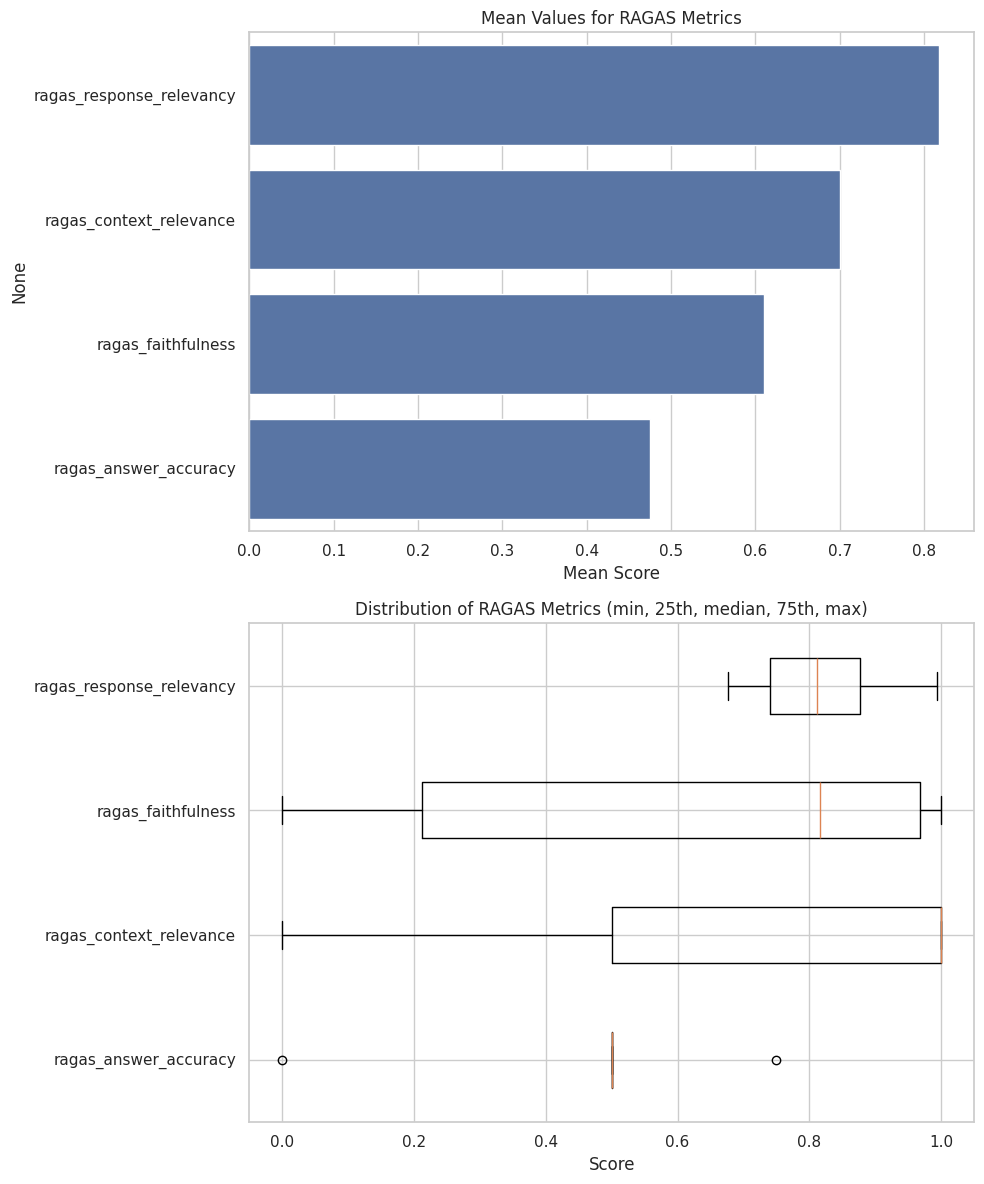

In [24]:
import pandas as pd
import numpy as np

def compute_ragas_summary_stats(csv_path):
    """
    Compute summary statistics for RAGAS evaluation metrics from a CSV file.
    
    Args:
        csv_path: Path to the CSV file containing RAGAS evaluation results
        
    Returns:
        DataFrame with summary statistics for each metric
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Identify the RAGAS feedback columns
    ragas_cols = [col for col in df.columns if col.startswith('feedback.ragas_')]
    
    if not ragas_cols:
        raise ValueError("No RAGAS feedback columns found in the CSV")
    
    # Create a dictionary to store the statistics
    stats = {}
    
    # Compute statistics for each RAGAS metric
    for col in ragas_cols:
        metric_name = col.replace('feedback.', '')
        values = df[col].dropna()
        
        stats[metric_name] = {
            'mean': values.mean(),
            'median': values.median(),
            'std': values.std(),
            'min': values.min(),
            'max': values.max(),
            'count': len(values),
            '25th': values.quantile(0.25),
            '75th': values.quantile(0.75)
        }
    
    # Convert to DataFrame for easier viewing
    stats_df = pd.DataFrame(stats).T
    
    # Also calculate average execution time
    if 'execution_time' in df.columns:
        avg_execution_time = df['execution_time'].mean()
        print(f"Average execution time: {avg_execution_time:.3f} seconds")
    
    return stats_df

def visualize_ragas_metrics(stats_df):
    """
    Create simple visualizations of the RAGAS metrics.
    
    Args:
        stats_df: DataFrame containing the summary statistics
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the style
    sns.set(style="whitegrid")
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot mean values as a bar chart
    means = stats_df['mean'].sort_values(ascending=False)
    sns.barplot(x=means.values, y=means.index, ax=ax1)
    ax1.set_title('Mean Values for RAGAS Metrics')
    ax1.set_xlabel('Mean Score')
    
    # Plot a box plot showing min, 25th, median, 75th, max
    data_to_plot = []
    labels = []
    
    for metric in stats_df.index:
        values = [
            stats_df.loc[metric, 'min'],
            stats_df.loc[metric, '25th'],
            stats_df.loc[metric, 'median'],
            stats_df.loc[metric, '75th'],
            stats_df.loc[metric, 'max']
        ]
        data_to_plot.append(values)
        labels.append(metric)
    
    # Create a box plot without the actual boxes
    ax2.boxplot(data_to_plot, labels=labels, vert=False)
    ax2.set_title('Distribution of RAGAS Metrics (min, 25th, median, 75th, max)')
    ax2.set_xlabel('Score')
    
    plt.tight_layout()
    plt.savefig('ragas_metrics_summary.png')
    plt.show()
    
    return fig

# Example usage
if __name__ == "__main__":
    # Replace with your CSV path
    csv_path = "ragas-rag-cohere-engineering-emb-all-mpnet-base-v2-cs512-co50-k10_results.csv"  # or the actual path to your saved CSV
    
    # Compute summary statistics
    stats_df = compute_ragas_summary_stats(csv_path)
    print("\nSummary Statistics:")
    print(stats_df)
    
    # Visualize the metrics
    visualize_ragas_metrics(stats_df)

Average execution time: 0.607 seconds

RAGAS Metrics Summary Statistics:
                              mean    median       std       min       max  \
ragas_answer_accuracy     0.475000  0.500000  0.218899  0.000000  0.750000   
ragas_context_relevance   0.700000  1.000000  0.421637  0.000000  1.000000   
ragas_faithfulness        0.610119  0.816667  0.408320  0.000000  1.000000   
ragas_response_relevancy  0.818171  0.811879  0.106742  0.677256  0.993943   

                          count      25th      75th  
ragas_answer_accuracy      10.0  0.500000  0.500000  
ragas_context_relevance    10.0  0.500000  1.000000  
ragas_faithfulness         10.0  0.212500  0.968750  
ragas_response_relevancy   10.0  0.739889  0.877336  

Answer vs Reference Comparison Summary:
                  char_length  word_count  sentence_count  tfidf_similarity
mean_output        298.800000   44.100000        2.100000               NaN
mean_reference     565.700000   82.600000        3.500000               N

/tmp/ipykernel_44860/3513628703.py:223: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_to_plot, labels=labels, vert=False)


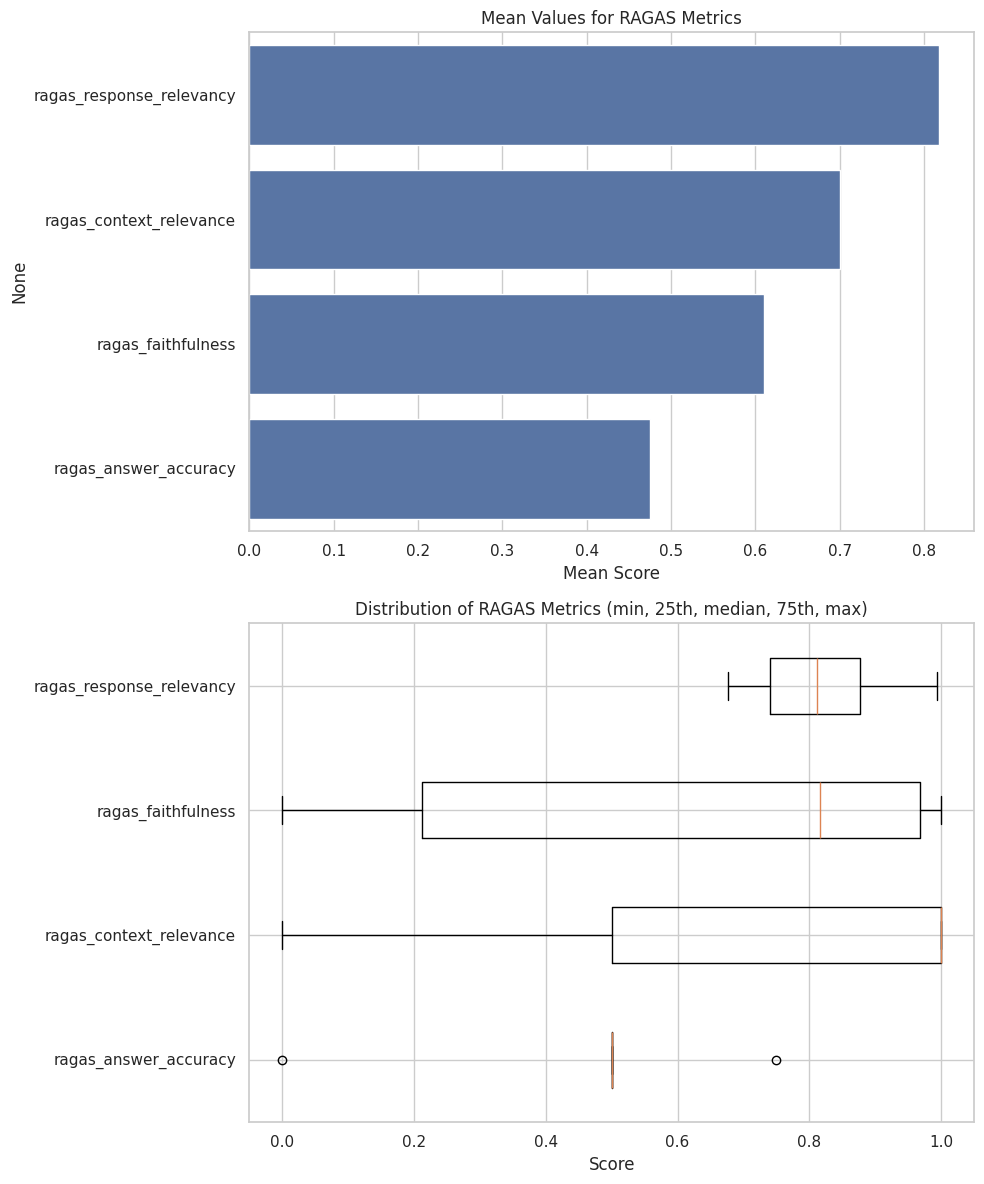

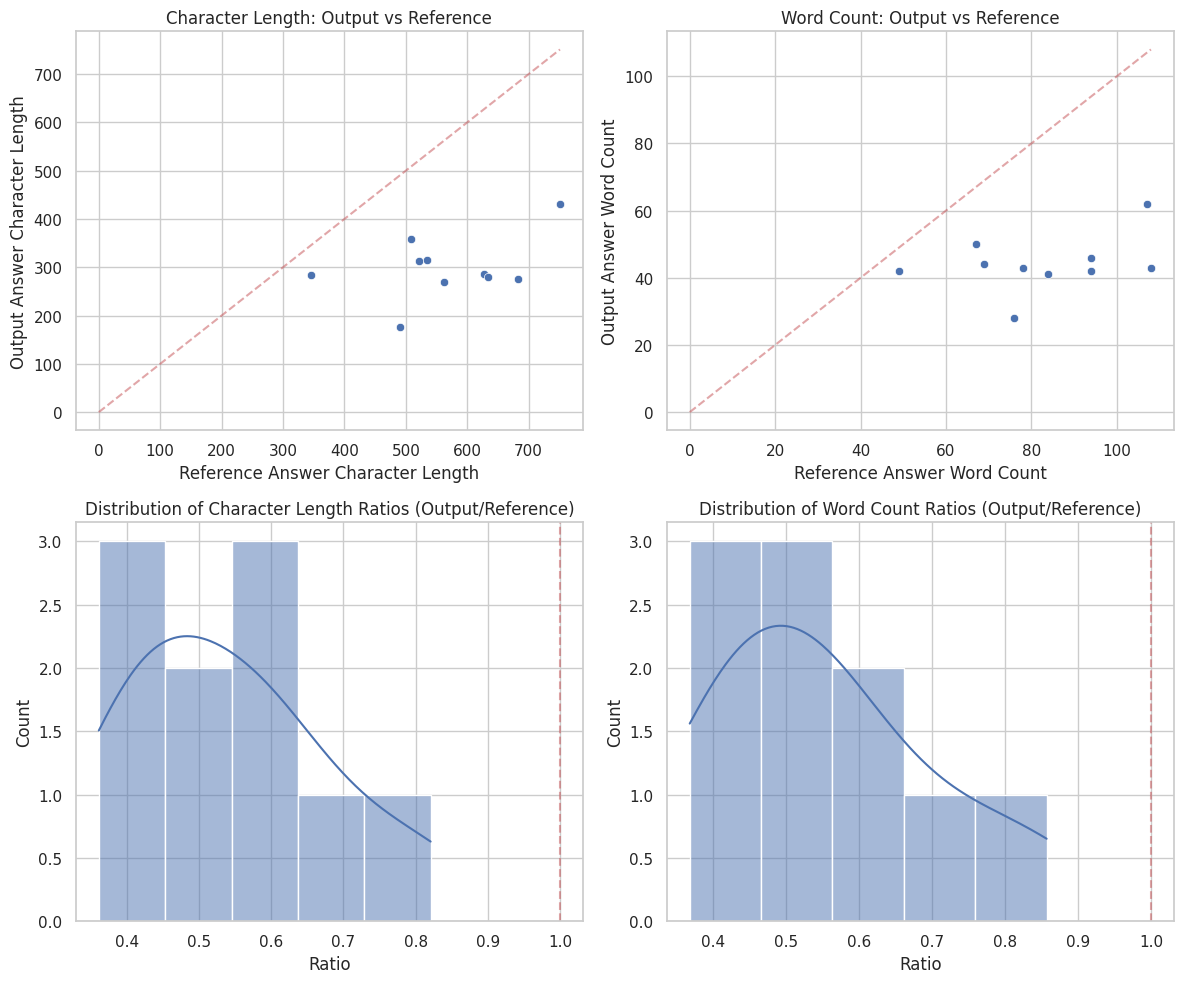

In [30]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_ragas_summary_stats(csv_path):
    """
    Compute summary statistics for RAGAS evaluation metrics from a CSV file.
    
    Args:
        csv_path: Path to the CSV file containing RAGAS evaluation results
        
    Returns:
        DataFrame with summary statistics for each metric
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Identify the RAGAS feedback columns
    ragas_cols = [col for col in df.columns if col.startswith('feedback.ragas_')]
    
    if not ragas_cols:
        raise ValueError("No RAGAS feedback columns found in the CSV")
    
    # Create a dictionary to store the statistics
    stats = {}
    
    # Compute statistics for each RAGAS metric
    for col in ragas_cols:
        metric_name = col.replace('feedback.', '')
        values = df[col].dropna()
        
        stats[metric_name] = {
            'mean': values.mean(),
            'median': values.median(),
            'std': values.std(),
            'min': values.min(),
            'max': values.max(),
            'count': len(values),
            '25th': values.quantile(0.25),
            '75th': values.quantile(0.75)
        }
    
    # Convert to DataFrame for easier viewing
    stats_df = pd.DataFrame(stats).T
    
    # Also calculate average execution time
    if 'execution_time' in df.columns:
        avg_execution_time = df['execution_time'].mean()
        print(f"Average execution time: {avg_execution_time:.3f} seconds")
    
    return stats_df, df

def simple_word_tokenize(text):
    """
    A simple word tokenizer that doesn't require NLTK.
    """
    # Remove punctuation and split by whitespace
    words = re.findall(r'\b\w+\b', text.lower())
    return words

def analyze_answer_vs_reference(df):
    """
    Compare the outputs.answer column to the reference.answer column.
    
    Args:
        df: DataFrame containing the evaluation results
        
    Returns:
        DataFrame with comparison statistics
    """
    # Make sure required columns exist
    if 'outputs.answer' not in df.columns or 'reference.answer' not in df.columns:
        raise ValueError("Required columns 'outputs.answer' and 'reference.answer' not found")
    
    # Create lists to store the statistics
    stats = []
    
    # Process each row
    for idx, row in df.iterrows():
        output = str(row['outputs.answer'])
        reference = str(row['reference.answer'])
        
        # Skip if any is empty
        if not output or not reference:
            continue
        
        # Calculate character length
        output_char_len = len(output)
        reference_char_len = len(reference)
        
        # Calculate word count (using simple tokenizer)
        output_words = simple_word_tokenize(output)
        reference_words = simple_word_tokenize(reference)
        output_word_count = len(output_words)
        reference_word_count = len(reference_words)
        
        # Calculate sentence count (naive approach)
        output_sentence_count = output.count('.') + output.count('!') + output.count('?')
        reference_sentence_count = reference.count('.') + reference.count('!') + reference.count('?')
        
        # Store the statistics
        stats.append({
            'example_id': row.get('example_id', f"example_{idx}"),
            'output_char_len': output_char_len,
            'reference_char_len': reference_char_len,
            'char_len_ratio': output_char_len / reference_char_len if reference_char_len > 0 else float('nan'),
            'output_word_count': output_word_count,
            'reference_word_count': reference_word_count,
            'word_count_ratio': output_word_count / reference_word_count if reference_word_count > 0 else float('nan'),
            'output_sentence_count': output_sentence_count,
            'reference_sentence_count': reference_sentence_count,
            'sentence_count_ratio': output_sentence_count / reference_sentence_count if reference_sentence_count > 0 else float('nan'),
        })
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(stats)
    
    # Calculate corpus-level TF-IDF similarity
    if len(stats) > 0:
        # Extract the text columns
        outputs = df['outputs.answer'].fillna('').astype(str).tolist()
        references = df['reference.answer'].fillna('').astype(str).tolist()
        
        # Calculate TF-IDF vectors
        vectorizer = TfidfVectorizer()
        try:
            all_docs = outputs + references
            tfidf_matrix = vectorizer.fit_transform(all_docs)
            
            # Calculate cosine similarity between each output and its reference
            n = len(outputs)
            similarities = []
            for i in range(n):
                output_vector = tfidf_matrix[i]
                reference_vector = tfidf_matrix[i + n]
                similarity = cosine_similarity(output_vector, reference_vector)[0][0]
                similarities.append(similarity)
                
            # Add to the stats DataFrame
            stats_df['tfidf_similarity'] = similarities
        except:
            print("Could not compute TF-IDF similarity")
    
    # Calculate summary statistics
    summary = {
        'char_length': {
            'mean_output': stats_df['output_char_len'].mean(),
            'mean_reference': stats_df['reference_char_len'].mean(),
            'median_output': stats_df['output_char_len'].median(),
            'median_reference': stats_df['reference_char_len'].median(),
            'mean_ratio': stats_df['char_len_ratio'].mean(),
            'median_ratio': stats_df['char_len_ratio'].median()
        },
        'word_count': {
            'mean_output': stats_df['output_word_count'].mean(),
            'mean_reference': stats_df['reference_word_count'].mean(),
            'median_output': stats_df['output_word_count'].median(),
            'median_reference': stats_df['reference_word_count'].median(),
            'mean_ratio': stats_df['word_count_ratio'].mean(),
            'median_ratio': stats_df['word_count_ratio'].median()
        },
        'sentence_count': {
            'mean_output': stats_df['output_sentence_count'].mean(),
            'mean_reference': stats_df['reference_sentence_count'].mean(),
            'median_output': stats_df['output_sentence_count'].median(),
            'median_reference': stats_df['reference_sentence_count'].median(),
            'mean_ratio': stats_df['sentence_count_ratio'].mean(),
            'median_ratio': stats_df['sentence_count_ratio'].median()
        }
    }
    
    # Add TF-IDF similarity stats if available
    if 'tfidf_similarity' in stats_df.columns:
        summary['tfidf_similarity'] = {
            'mean': stats_df['tfidf_similarity'].mean(),
            'median': stats_df['tfidf_similarity'].median(),
            'min': stats_df['tfidf_similarity'].min(),
            'max': stats_df['tfidf_similarity'].max()
        }
    
    return pd.DataFrame(summary), stats_df

def visualize_ragas_metrics(stats_df):
    """
    Create simple visualizations of the RAGAS metrics.
    
    Args:
        stats_df: DataFrame containing the summary statistics
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the style
    sns.set(style="whitegrid")
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot mean values as a bar chart
    means = stats_df['mean'].sort_values(ascending=False)
    sns.barplot(x=means.values, y=means.index, ax=ax1)
    ax1.set_title('Mean Values for RAGAS Metrics')
    ax1.set_xlabel('Mean Score')
    
    # Plot a box plot showing min, 25th, median, 75th, max
    data_to_plot = []
    labels = []
    
    for metric in stats_df.index:
        values = [
            stats_df.loc[metric, 'min'],
            stats_df.loc[metric, '25th'],
            stats_df.loc[metric, 'median'],
            stats_df.loc[metric, '75th'],
            stats_df.loc[metric, 'max']
        ]
        data_to_plot.append(values)
        labels.append(metric)
    
    # Create a box plot without the actual boxes
    ax2.boxplot(data_to_plot, labels=labels, vert=False)
    ax2.set_title('Distribution of RAGAS Metrics (min, 25th, median, 75th, max)')
    ax2.set_xlabel('Score')
    
    plt.tight_layout()
    plt.savefig('ragas_metrics_summary.png')
    
    return fig

def visualize_answer_comparisons(comparison_df):
    """
    Create visualizations comparing output answers with reference answers.
    
    Args:
        comparison_df: DataFrame with detailed comparison stats
        
    Returns:
        Matplotlib figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the style
    sns.set(style="whitegrid")
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Character length comparison
    sns.scatterplot(
        x='reference_char_len', 
        y='output_char_len', 
        data=comparison_df,
        ax=axes[0, 0]
    )
    
    # Add a diagonal line for reference
    max_char = max(comparison_df['reference_char_len'].max(), comparison_df['output_char_len'].max())
    axes[0, 0].plot([0, max_char], [0, max_char], 'r--', alpha=0.5)
    
    axes[0, 0].set_title('Character Length: Output vs Reference')
    axes[0, 0].set_xlabel('Reference Answer Character Length')
    axes[0, 0].set_ylabel('Output Answer Character Length')
    
    # Plot 2: Word count comparison
    sns.scatterplot(
        x='reference_word_count', 
        y='output_word_count', 
        data=comparison_df,
        ax=axes[0, 1]
    )
    
    # Add a diagonal line for reference
    max_word = max(comparison_df['reference_word_count'].max(), comparison_df['output_word_count'].max())
    axes[0, 1].plot([0, max_word], [0, max_word], 'r--', alpha=0.5)
    
    axes[0, 1].set_title('Word Count: Output vs Reference')
    axes[0, 1].set_xlabel('Reference Answer Word Count')
    axes[0, 1].set_ylabel('Output Answer Word Count')
    
    # Plot 3: Distribution of character length ratios
    sns.histplot(
        comparison_df['char_len_ratio'],
        kde=True,
        ax=axes[1, 0]
    )
    axes[1, 0].axvline(x=1, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Distribution of Character Length Ratios (Output/Reference)')
    axes[1, 0].set_xlabel('Ratio')
    
    # Plot 4: Distribution of word count ratios
    sns.histplot(
        comparison_df['word_count_ratio'],
        kde=True,
        ax=axes[1, 1]
    )
    axes[1, 1].axvline(x=1, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Distribution of Word Count Ratios (Output/Reference)')
    axes[1, 1].set_xlabel('Ratio')
    
    plt.tight_layout()
    plt.savefig('answer_comparison_summary.png')
    
    return fig

# Example usage
if __name__ == "__main__":
    # Replace with your CSV path
    csv_path = "ragas-rag-cohere-engineering-emb-all-mpnet-base-v2-cs512-co50-k10_results.csv"  # or the actual path to your saved CSV
    
    # Compute summary statistics
    stats_df, raw_df = compute_ragas_summary_stats(csv_path)
    print("\nRAGAS Metrics Summary Statistics:")
    print(stats_df)
    
    # Analyze answer vs reference comparison
    comparison_summary, comparison_details = analyze_answer_vs_reference(raw_df)
    print("\nAnswer vs Reference Comparison Summary:")
    print(comparison_summary)
    
    # Print some detailed statistics about the answer comparisons
    print("\nDetailed Answer Comparison Statistics:")
    print(f"Average output length: {comparison_details['output_char_len'].mean():.1f} characters vs " +
          f"reference length: {comparison_details['reference_char_len'].mean():.1f} characters")
    print(f"Average output word count: {comparison_details['output_word_count'].mean():.1f} words vs " +
          f"reference word count: {comparison_details['reference_word_count'].mean():.1f} words")
    
    if 'tfidf_similarity' in comparison_details.columns:
        print(f"Average TF-IDF similarity between output and reference: {comparison_details['tfidf_similarity'].mean():.4f}")
    
    # Create visualizations
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        ragas_fig = visualize_ragas_metrics(stats_df)
        comparison_fig = visualize_answer_comparisons(comparison_details)
        plt.show()
    except ImportError:
        print("Matplotlib and/or seaborn not available for visualization.")

In [33]:
import os
from loguru import logger

experiment_dir = "../results/phase1_standard_20250404_201205"
experiment_id = None

experiment_dir = os.path.abspath(experiment_dir)

# Create analysis subdirectory
analysis_dir = os.path.join(experiment_dir, "analysis")
os.makedirs(analysis_dir, exist_ok=True)

# Load the experiment plan
plan_path = os.path.join(experiment_dir, "experiment_plan.json")
if not os.path.exists(plan_path):
    logger.warning(f"Experiment plan not found at {plan_path}")

In [34]:
import json

with open(plan_path, "r") as f:
    experiment_plan = json.load(f)

# Load the results
results_path = os.path.join(experiment_dir, "results.json")
if not os.path.exists(results_path):
    logger.warning(f"Results not found at {results_path}")

In [35]:
with open(results_path, "r") as f:
    experiment_results = json.load(f)

# Extract experiment IDs
experiment_ids = [result["experiment_id"] for result in experiment_results if result.get("success", False)]

if not experiment_ids:
    logger.warning(f"No successful experiments found in {results_path}")

In [36]:
experiment_ids

['rag-cohere-engineering-emb-all-distilroberta-v1-cs128-co0-k4',
 'rag-cohere-engineering-emb-multi-qa-mpnet-base-cos-v1-cs128-co0-k4',
 'rag-cohere-marketing-emb-all-distilroberta-v1-cs128-co0-k4',
 'rag-cohere-marketing-emb-multi-qa-mpnet-base-cos-v1-cs128-co0-k4']

In [10]:
experiment_plan

[{'rag_type': 'cohere',
  'team_type': 'engineering',
  'embedding_model': 'all-distilroberta-v1',
  'chunk_size': 128,
  'chunk_overlap': 0,
  'top_k': 4,
  'retriever_type': 'similarity',
  'retriever_kwargs': {},
  'templates': {'engineering': 'templates/engineering_template_3.txt',
   'marketing': 'templates/marketing_template_2.txt'}},
 {'rag_type': 'cohere',
  'team_type': 'engineering',
  'embedding_model': 'multi-qa-mpnet-base-cos-v1',
  'chunk_size': 128,
  'chunk_overlap': 0,
  'top_k': 4,
  'retriever_type': 'similarity',
  'retriever_kwargs': {},
  'templates': {'engineering': 'templates/engineering_template_3.txt',
   'marketing': 'templates/marketing_template_2.txt'}},
 {'rag_type': 'cohere',
  'team_type': 'marketing',
  'embedding_model': 'all-distilroberta-v1',
  'chunk_size': 128,
  'chunk_overlap': 0,
  'top_k': 4,
  'retriever_type': 'similarity',
  'retriever_kwargs': {},
  'templates': {'engineering': 'templates/engineering_template_3.txt',
   'marketing': 'templa

In [31]:
import pandas as pd

def fetch_langsmith_data(experiment_id, output_dir):
    """
    Fetch detailed results from LangSmith API for a given experiment ID.
    
    Args:
        experiment_id: The experiment ID in LangSmith
        output_dir: Directory to save the results
        
    Returns:
        DataFrame with detailed results
    """
    from langsmith import Client
    
    client = Client()
    
    try:
        # First, find the project name where runs are stored
        # In your setup, all runs appear to be in the same project: "w267-final-project-rag-pipeline"
        project_name = "w267-final-project-rag-pipeline"
        
        # Find runs that match the experiment ID in tags or metadata
        all_runs = []
        
        # List all runs from the project
        runs = client.list_runs(
            project_name=project_name,
            execution_order=1,  # Only root runs
            # Try to filter by experiment ID in metadata if possible
            # metadata_filter={"experiment_id": experiment_id}
        )
        
        for run in runs:
            # Check if this run belongs to the experiment we're looking for
            # This could be in tags, metadata, or trace ID
            if hasattr(run, "tags") and experiment_id in str(run.tags):
                all_runs.append(run)
            elif hasattr(run, "metadata") and experiment_id in str(run.metadata):
                all_runs.append(run)
            elif hasattr(run, "trace_id") and experiment_id in str(run.trace_id):
                all_runs.append(run)
        
        if not all_runs:
            # If we couldn't find runs specifically for this experiment,
            # let's just grab recent runs as a fallback
            logger.warning(f"No runs found specifically for experiment {experiment_id}")
            logger.info("Fetching 10 most recent runs as a fallback")
            
            # Get the 10 most recent runs
            recent_runs = list(client.list_runs(
                project_name=project_name,
                execution_order=1,
                limit=10
            ))
            all_runs = recent_runs
        
        # Collect data from runs
        data = []
        for run in all_runs:
            # Extract question and answer
            inputs = run.inputs or {}
            outputs = run.outputs or {}
            
            if not inputs or not outputs:
                continue
                
            # Extract question from inputs
            question = ""
            if "messages" in inputs:
                # Handle chat format
                for message in inputs["messages"]:
                    if isinstance(message, list) and len(message) > 0:
                        # Sometimes messages are nested
                        for submsg in message:
                            if isinstance(submsg, dict) and "content" in submsg:
                                content = submsg.get("content", "")
                                # Extract question from the instruction format
                                if "QUESTION:" in content:
                                    parts = content.split("QUESTION:")
                                    if len(parts) > 1:
                                        question_part = parts[1].split("\n\n")[0].strip()
                                        question = question_part
            elif "question" in inputs:
                # Direct question format
                question = inputs["question"]
            
            # Extract answer from outputs
            answer = ""
            if "generations" in outputs:
                # Handle generations format
                generations = outputs["generations"]
                if generations and isinstance(generations, list) and len(generations) > 0:
                    for gen in generations[0]:
                        if "text" in gen:
                            answer = gen["text"]
                            break
                        elif "message" in gen and "content" in gen["message"]:
                            answer = gen["message"]["content"]
                            break
            elif "answer" in outputs:
                # Direct answer format
                answer = outputs["answer"]
            
            # Find reference answer and feedback scores in child runs
            ref_answer = ""
            feedback = {}
            
            if hasattr(run, "trace_id"):
                # Get all runs in this trace
                child_runs = list(client.list_runs(trace_id=run.trace_id))
                
                for child_run in child_runs:
                    # Check for feedback runs
                    if child_run.run_type == "feedback":
                        key = child_run.name.replace("feedback:", "").strip()
                        value = child_run.outputs.get("score") if child_run.outputs else None
                        if key and value is not None:
                            feedback[f"feedback.{key}"] = value
                    
                    # Look for reference answers
                    if child_run.name == "reference" and child_run.inputs:
                        ref_answer = child_run.inputs.get("answer", "")
            
            # Create a record
            record = {
                "inputs.question": question,
                "outputs.answer": answer,
                "reference.answer": ref_answer,
                "error": run.error if hasattr(run, "error") else None,
                "execution_time": (run.end_time - run.start_time).total_seconds() 
                                  if hasattr(run, "end_time") and run.end_time and run.start_time else None,
                "example_id": run.reference_example_id if hasattr(run, "reference_example_id") else None,
                "id": str(run.id) if hasattr(run, "id") else "",
                "trace_id": str(run.trace_id) if hasattr(run, "trace_id") else ""
            }
            
            # Add feedback scores
            record.update(feedback)
            
            # Only add records with actual content
            if question and answer:
                data.append(record)
        
        # Create DataFrame
        df = pd.DataFrame(data)
        
        # Save to CSV
        csv_path = os.path.join(output_dir, f"{experiment_id}_detailed.csv")
        df.to_csv(csv_path, index=False)
        logger.info(f"Saved detailed results to {csv_path}")
        
        return df
    
    except Exception as e:
        logger.error(f"Error fetching data from LangSmith: {e}", exc_info=True)
        return pd.DataFrame()

In [ ]:
# Use the provided experiment ID or the first one from results
if experiment_id is None and experiment_ids:
    experiment_id = experiment_ids[0]

# Fetch detailed results from LangSmith
if experiment_id:
    detailed_df = fetch_langsmith_data(experiment_id, analysis_dir)
else:
    logger.warning("No experiment ID provided or found in results")
    detailed_df = pd.DataFrame()

2025-04-04 20:54:45.598 | WARNING  | __main__:fetch_langsmith_data:47 - No runs found specifically for experiment rag-cohere-engineering-emb-all-distilroberta-v1-cs128-co0-k4
2025-04-04 20:54:45.598 | INFO     | __main__:fetch_langsmith_data:48 - Fetching 10 most recent runs as a fallback
2025-04-04 20:54:56.079 | INFO     | __main__:fetch_langsmith_data:151 - Saved detailed results to /home/ubuntu/w267-final-project-rag-pipeline/results/phase1_standard_20250404_201205/analysis/rag-cohere-engineering-emb-all-distilroberta-v1-cs128-co0-k4_detailed.csv


: 

In [2]:
from langsmith import Client
client = Client()

In [25]:
from datetime import datetime
from datetime import timedelta

todays_llm_runs = client.list_runs( project_name="", start_time=datetime.now() - timedelta(days=1), run_type="llm", )

In [30]:
for run in todays_llm_runs:
    print(run)

id=UUID('3fff7c41-c914-40b2-9eac-5aaf885e3f17') name='ChatCohere' start_time=datetime.datetime(2025, 4, 4, 20, 16, 17, 996613) run_type='llm' end_time=datetime.datetime(2025, 4, 4, 20, 16, 18, 586262) extra={'batch_size': 1, 'inputs_is_truthy': True, 'invocation_params': {'_type': 'cohere-chat', 'model': 'command-r', 'stop': None}, 'metadata': {'LANGSMITH_ENDPOINT': 'https://api.smith.langchain.com', 'LANGSMITH_PROJECT': 'w267-final-project-rag-pipeline', 'LANGSMITH_TRACING': 'true', 'engineering_template_path': 'templates/engineering_template_3.txt', 'example_version': '2025-04-04T20:14:20.843928+00:00', 'llm': {'api_key_provided': True, 'family': 'cohere', 'model_name': 'command-r'}, 'ls_method': 'traceable', 'ls_model_name': 'command-r', 'ls_model_type': 'chat', 'ls_provider': 'cohere', 'ls_temperature': None, 'marketing_template_path': 'templates/marketing_template_2.txt', 'num_repetitions': 1, 'retriever': {'kwargs': {'k': 4}, 'type': 'similarity'}, 'revision_id': '008bda1-dirty',

In [5]:
# List all projects/experiments
experiments = client.list_projects()

# Extract just the names
experiment_names = [exp.name for exp in experiments]

In [6]:
experiment_names

['ragas-rag-cohere-engineering-emb-all-mpnet-base-v2-cs2048-co50-k4-mmr-4fcfbbf2',
 'evaluators',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k4-similarity_score_threshold-0.5-fa482a34',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k4-multi_query-0e0789a7',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k4-mmr-977ceab7',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k4-similarity_score_threshold-0.8-52d60819',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k4-similarity_score_threshold-0.5-2fd62586',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k12-e98ed0c6',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k8-510ab02b',
 'ragas-rag-cohere-engineering-emb-all-mpnet-base-v2-cs2048-co100-k4-54318433',
 'ragas-rag-cohere-marketing-emb-all-mpnet-base-v2-cs512-co100-k4-fa0bd904',
 'ragas-rag-cohere-marketing-emb-all-MiniLM-L6-v2-cs128-co0-k4-1ee02f64',
 'ragas-rag-cohere-eng

In [19]:
from langsmith import Client

def save_filtered_experiments_to_file(output_file="filtered_experiments.txt"):
    # Initialize the LangSmith client
    client = Client()
    
    # List all projects/experiments
    all_experiments = client.list_projects()
    
    # Filter experiments by name pattern
    filtered_experiments = []
    for exp in all_experiments:
        if ("ragas-rag-cohere-marketing-emb-" in exp.name or 
            "ragas-rag-cohere-engineering-emb-" in exp.name):
            filtered_experiments.append(exp.name)
    
    # Save to text file
    with open(output_file, 'w') as f:
        for name in filtered_experiments:
            f.write(f"{name}\n")
    
    print(f"Saved {len(filtered_experiments)} experiment names to {output_file}")
    return filtered_experiments

# Run the function
if __name__ == "__main__":
    save_filtered_experiments_to_file()

Saved 81 experiment names to filtered_experiments.txt
